# Loading packages 

In [85]:
import pandas as pd
import inflection
import math
import numpy as np
import datetime
import scipy
import scipy.stats as ss
import seaborn as sns
import matplotlib.pyplot as plt 



from matplotlib import gridspec 
from IPython.core.display import HTML 
from IPython.display import Image

from boruta import BorutaPy
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder
from sklearn.ensemble import RandomForestRegressor

# Loading Data

In [2]:
df_sales_raw = pd.read_csv('train.csv', low_memory = False)
df_store_raw = pd.read_csv('store.csv', low_memory = False)

# merge

df_raw = pd.merge(df_sales_raw, df_store_raw, how = 'left', on ='Store')

In [3]:
df_raw.shape

(1017209, 18)

In [4]:
df_raw.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


# Data Description 

In [5]:
df1 = df_raw.copy()

### Renaming columns

In [6]:
df_raw.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

In [7]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
           'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment','CompetitionDistance', 'CompetitionOpenSinceMonth',
           'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval']
snakecase = lambda x: inflection.underscore(x)

cols_new = list(map(snakecase, cols_old))

#rename
df1.columns = cols_new

### Data Dimensions

In [8]:
print('Number of Rows: {}'.format(df1.shape[0]))
print('Number of Columns: {}'.format(df1.shape[1]))

Number of Rows: 1017209
Number of Columns: 18


### Data types

In [9]:
df1['date']= pd.to_datetime(df1['date'])
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

### Checking NA's

In [10]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

### Fillout NA's

In [11]:
df1.sample()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval
1014145,281,4,2013-01-03,5301,512,1,0,0,1,d,c,6970.0,9.0,2011.0,0,NaN,NaN,NaN


In [12]:
#competition_distance              
df1['competition_distance'] = df1['competition_distance'].apply(lambda x:200000.0 if math.isnan(x) else x)

#competition_open_since_month    
df1['competition_open_since_month']= df1.apply(lambda x : x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'],axis =1)

#competition_open_since_year     
df1['competition_open_since_year']= df1.apply(lambda x : x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'],axis =1)                       

#promo2_since_week               
df1['promo2_since_week']= df1.apply(lambda x : x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'],axis =1)                       

#promo2_since_year               
df1['promo2_since_year']= df1.apply(lambda x : x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'],axis =1)                       

#promo_interval                  
month_map = {1:'Jan',2:'Fev',3:'Mar',4:'Apr',5:'May',6:'Jun',7:'Jul',8:'Aug',9:'Sep',10:'Oct',11:'Nov',12:'Dec',}

df1['promo_interval'].fillna(0,inplace=True)

df1['month_map'] = df1['date'].dt.month.map(month_map)

df1['is_promo']= df1[['promo_interval', 'month_map']].apply(lambda x:0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis = 1 )




In [13]:
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

### Change types

In [14]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

In [15]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)

df1['promo2_since_week']=df1['promo2_since_week'].astype(int)
df1['promo2_since_year']=df1['promo2_since_year'].astype(int)

### Descriptive Statistics 

In [16]:
num_attributes = df1.select_dtypes(include = ['int64','int32','float64'])
cat_attributes = df1.select_dtypes(exclude = ['int64','int32', 'float64','datetime64[ns]'])

In [17]:
num_attributes.sample(2)

,store,day_of_week,sales,customers,open,promo,school_holiday,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo
775289,35,1,7043,621,1,0,1,7660.0,10,2000,1,1,2012,0
849372,528,5,17087,1370,1,1,0,20620.0,5,2013,1,37,2009,0


#### Numerical Attributes

In [18]:
# Central Tendency - mean, median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

# Dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min )).T
d3 = pd.DataFrame(num_attributes.apply(max )).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max()-x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

# Concatenate 
m = pd.concat([d2,d3,d4,ct1,ct2,d1,d5,d6]).T.reset_index()
m.columns = ['attributes','min','max','range','mean','median','std','skew','kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


C:\Users\Windows\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='competition_distance', ylabel='Density'>

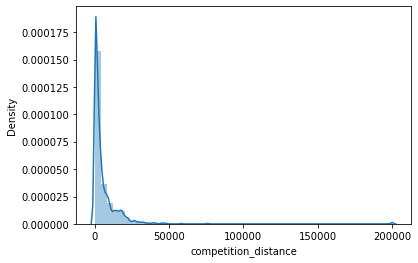

In [19]:
sns.distplot(df1['competition_distance'])

### Categorial Atrributes

In [20]:
cat_attributes.apply(lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

<AxesSubplot:xlabel='assortment', ylabel='sales'>

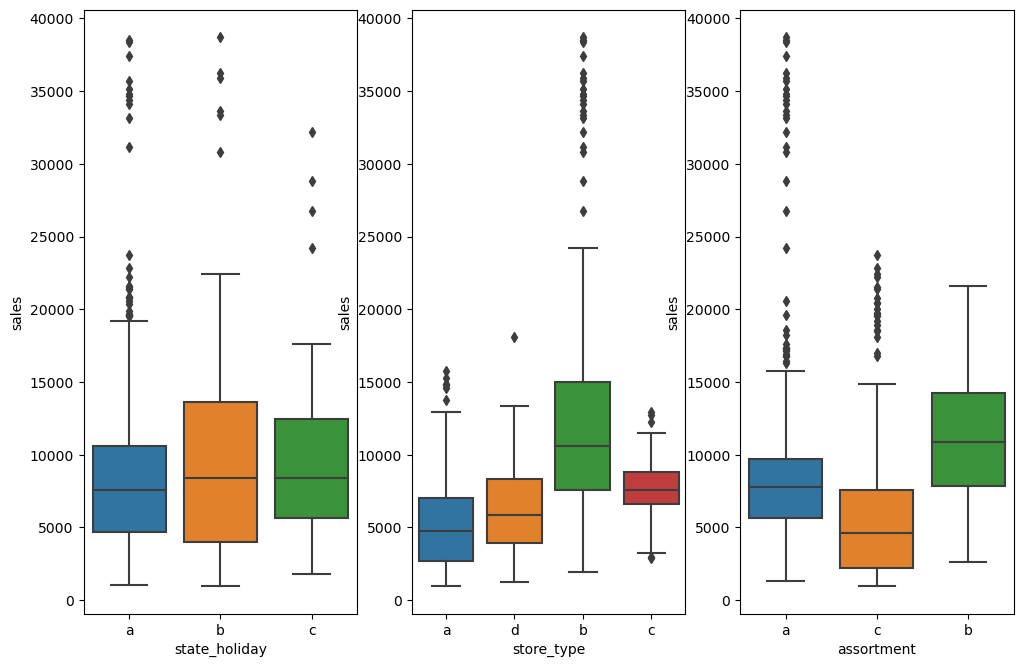

In [21]:
aux_1 = df1[(df1['state_holiday'] != '0') & (df1['sales']>0)] 

plt.figure(figsize=(12,8), dpi= 100, facecolor='w', edgecolor='k')
plt.subplot(1,3,1)
sns.boxplot(x = 'state_holiday', y = 'sales',  data = aux_1)

plt.subplot(1,3,2)
sns.boxplot(x = 'store_type', y = 'sales',  data = aux_1)

plt.subplot(1,3,3)
sns.boxplot(x = 'assortment', y = 'sales',  data = aux_1)


#  Feature engineering 

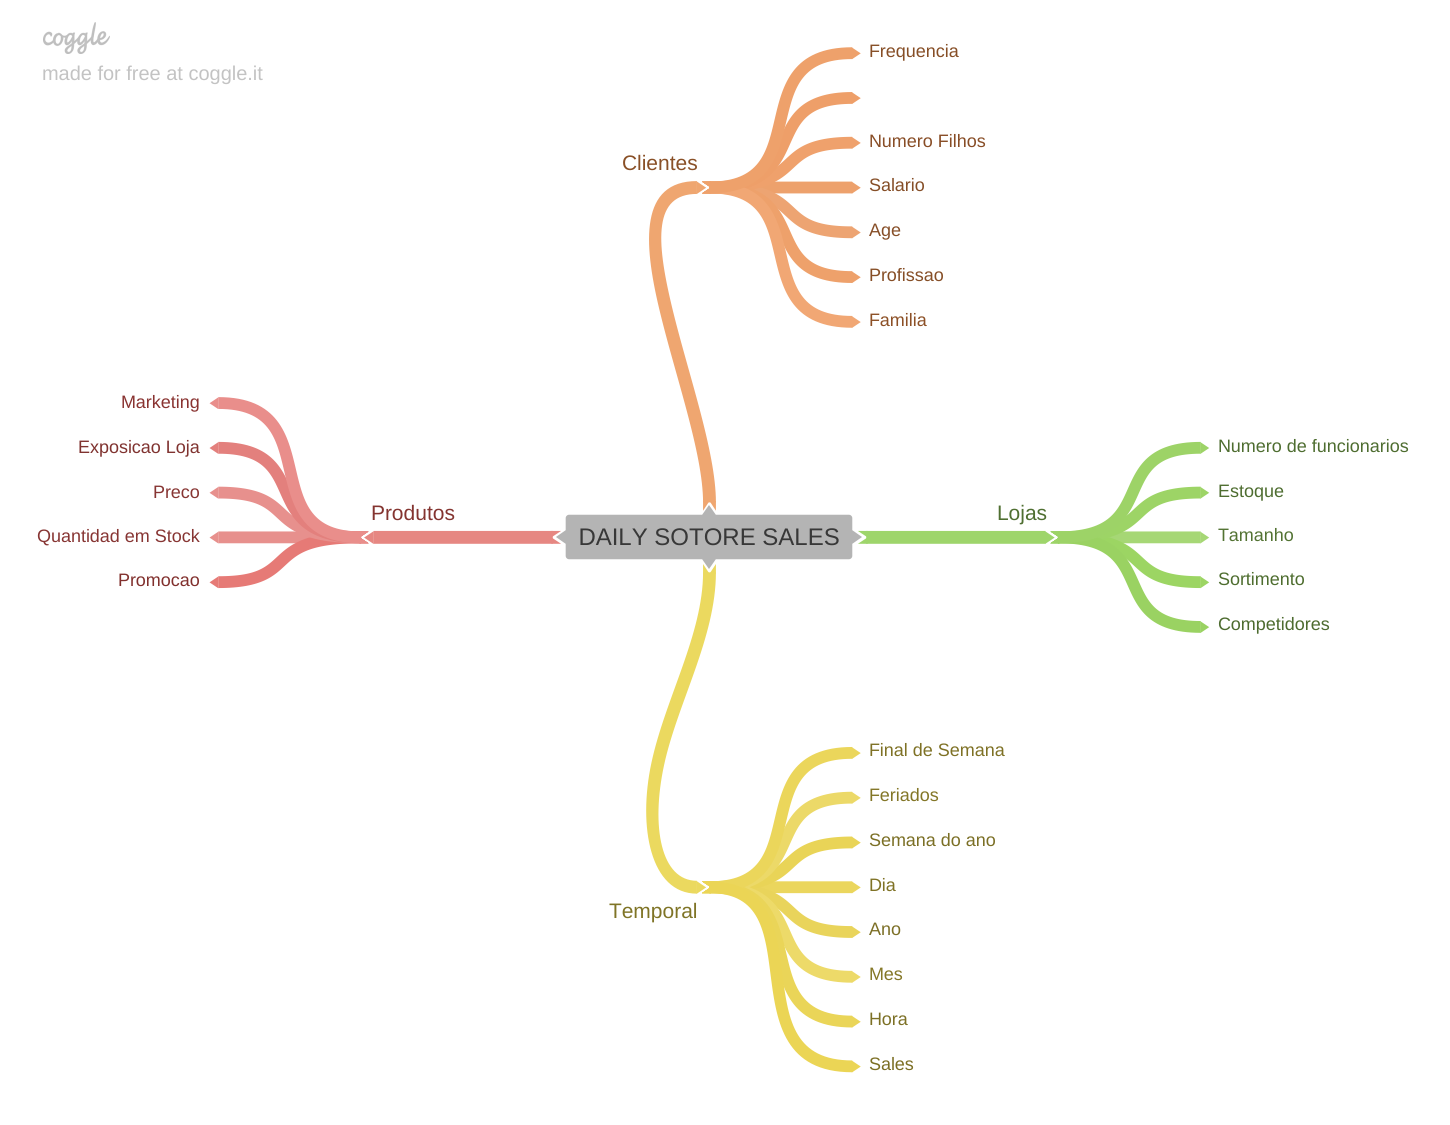

In [22]:
Image('img/DAILY_SOTORE_SALES.png')

## Hypothesis creation

### Store hypothesis

**1.** Higher number of employees should lead to higher selling volume

**2.** Higher stocked stores should lead to higher selling volume

**3.** Bigger stores should lead to higher selling volume

**4.** Better assortment in stores should lead to higher selling volume

**5.** Stores having competitors nearby should have less selling volume

**6.** Stores having lasting competitors nearby should have less selling volume

### Product hypothesis

**1.** Stores investing more in marketing should lead to higher selling volume

**2.** The more products being exposed in showcase should lead to higher selling volume

**3.** Stores displaying less priced product should lead to higher selling volume

**4.** Stores displaying less priced product longer should lead to higher selling volume

**5.** The more aggressive a promo is, the higher the selling volume

**6.** Stores displaying longer promos should have a higher selling volume 

**7.** More days with an active promo should lead to higher selling volume 

**8.** Stores displaying more consecutive promos should have higher selling volume

### Time hypothesis

**1.** Stores having more holidays should lead to lesser selling volume

**2.** Stores should have higher sellings through years

**3.** Stores should have higher selling volume on second semester each year

**4.** Stores should have higher selling volume after day 10 of month

**5.** Stores should have lesser selling volume on weekends

**6.** Stores shoudl have lesser selling volume on school holidays

## Final list of hypothesis. 

**1.** Better assortment in stores should lead to higher selling volume

**2.** Stores having competitors nearby should have less selling volume

**3.** Stores having lasting competitors nearby should have less selling volume

**4.** Stores displaying longer promos should have a higher selling volume 

**5.** More days with an active promo should lead to higher selling volume 

**6.** Stores displaying more consecutive promos should have higher selling volume

**7.** Stores having more holidays should lead to lesser selling volume

**8.** Stores should have higher sellings through years

**9.** Stores should have higher selling volume on second semester each year

**10.** Stores should have higher selling volume after day 10 of month

**11.** Stores should have lesser selling volume on weekends

**12.** Stores shoudl have lesser selling volume on school holidays

## Feature engineering

In [23]:
# year
df1['year'] = df1['date'].dt.year
# month
df1['month'] = df1['date'].dt.month
# day
df1['day'] = df1['date'].dt.day
# week of the year
df1['week_of_year'] = df1['date'].dt.weekofyear
# year week
df1['year_week'] = df1['date'].dt.strftime('%Y-%W')

# competition since 
df1['competition_since'] = df1.apply(lambda x: datetime.datetime(year= x['competition_open_since_year'], month=x['competition_open_since_month'], day=1),axis=1)
df1['competition_time_month'] = ((df1['date']-df1['competition_since'])/30).apply(lambda x: x.days).astype(int)

# promo since
df1['promo_since'] = df1['promo2_since_year'].astype(str) + '-' + df1['promo2_since_week'].astype(str)
df1['promo_since'] = df1['promo_since'].apply(lambda x: datetime.datetime.strptime(x+'-1','%Y-%W-%w') - datetime.timedelta(days= 7))
df1['promo_time_week'] = ((df1['date']-df1['promo_since'])/7).apply(lambda x: x.days).astype(int)
# assortment
df1['assortment'] = df1['assortment'].apply(lambda x: 'basic' if x =='a' else 'extra' if x == 'b' else 'extended')
# state holiday
df1['state_holiday'] = df1['state_holiday'].apply(lambda x: 'public_holiday' if x =='a' else 'eastern_holiday' if x == 'b' else 'christimas' if x == 'c' else 'regular_day')

<ipython-input-23-4e767970fd6c>:8: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  df1['week_of_year'] = df1['date'].dt.weekofyear


In [24]:
df1.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


In [25]:
df1['assortment']

0             basic
1             basic
2             basic
3          extended
4             basic
             ...   
1017204       basic
1017205    extended
1017206    extended
1017207    extended
1017208    extended
Name: assortment, Length: 1017209, dtype: object

# Data Filtering 

In [26]:
df3 = df1.copy()

In [27]:
df3.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,...,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,555,1,1,regular_day,1,c,...,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,625,1,1,regular_day,1,a,...,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,821,1,1,regular_day,1,a,...,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1498,1,1,regular_day,1,c,...,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,559,1,1,regular_day,1,a,...,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0


## Row filtering

In [28]:
df3['open']

0          1
1          1
2          1
3          1
4          1
          ..
1017204    0
1017205    0
1017206    0
1017207    0
1017208    0
Name: open, Length: 1017209, dtype: int64

In [29]:
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

## Column Selection

In [30]:
cols_drop = ['customers', 'open','promo_interval','month_map']
df3 = df3.drop(cols_drop, axis = 1)

In [31]:
df3.columns

Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'state_holiday',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo', 'year', 'month',
       'day', 'week_of_year', 'year_week', 'competition_since',
       'competition_time_month', 'promo_since', 'promo_time_week'],
      dtype='object')

# Exploratory Data Analysis (EDA)

In [32]:
df4 = df3.copy()

## Univariate Analysis

### Response Variable

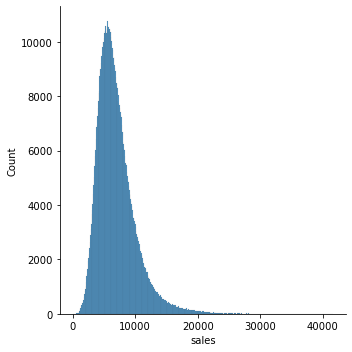

In [33]:
sns.displot(df4['sales'])

### Numerical Variable

In [34]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 10]

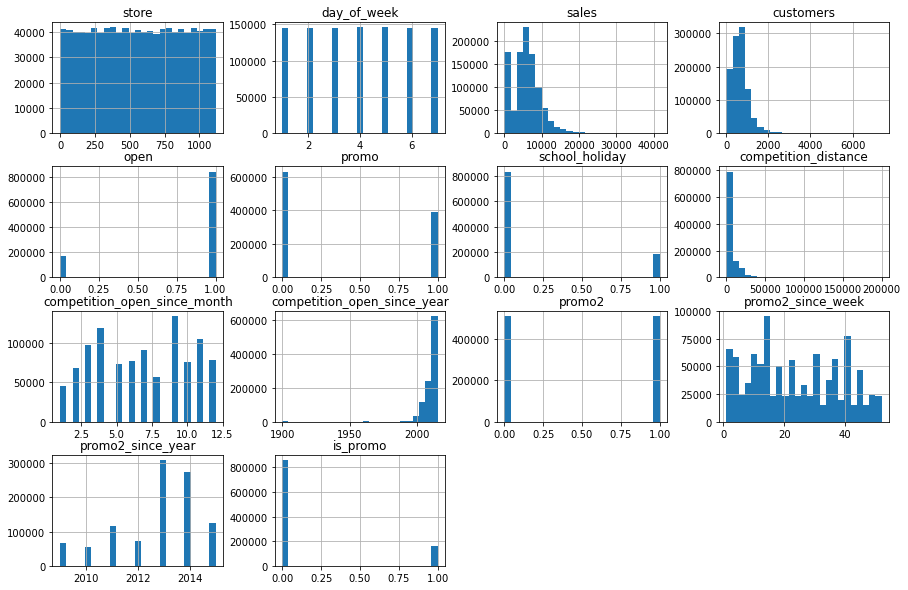

In [35]:
num_attributes.hist(bins =25);

### Categorical Variable

In [36]:
df4.columns

Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'state_holiday',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo', 'year', 'month',
       'day', 'week_of_year', 'year_week', 'competition_since',
       'competition_time_month', 'promo_since', 'promo_time_week'],
      dtype='object')

In [37]:
set(df4['assortment'].tolist())

{'basic', 'extended', 'extra'}

C:\Users\Windows\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\Windows\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\Windows\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='sales', ylabel='Density'>

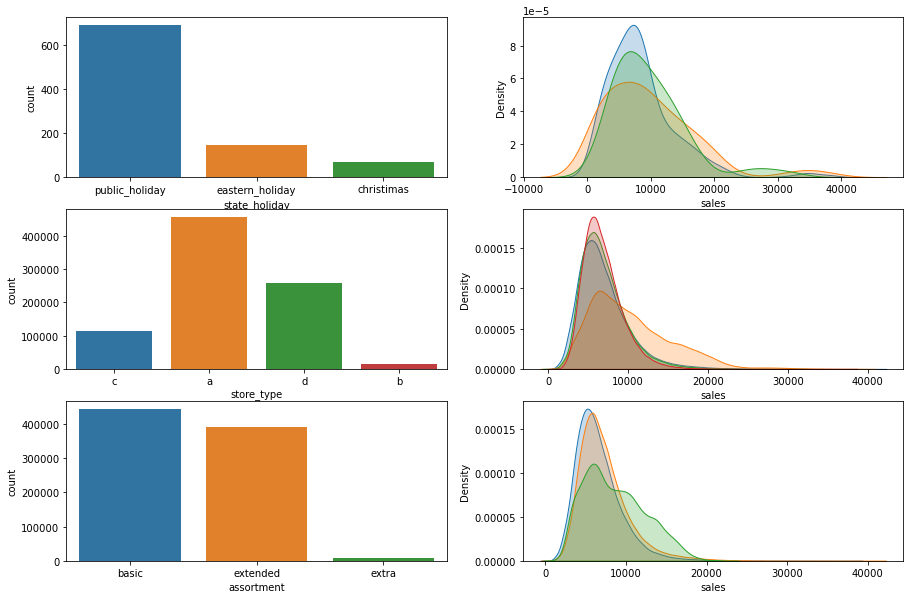

In [38]:
## State holiday
plt.subplot(3,2,1)
a= df4[df4['state_holiday'] != 'regular_day']
sns.countplot(a['state_holiday'])
plt.subplot(3,2,2)
sns.kdeplot(df4[df4['state_holiday'] == 'public_holiday']['sales'], label = 'public_holiday', shade =True)
sns.kdeplot(df4[df4['state_holiday'] == 'eastern_holiday']['sales'], label = 'eastern_holiday', shade =True)
sns.kdeplot(df4[df4['state_holiday'] == 'christimas']['sales'], label = 'christimas', shade =True)

# store_type

plt.subplot(3,2,3)
sns.countplot(df4['store_type'])

plt.subplot(3,2,4)
sns.kdeplot(df4[df4['store_type'] == 'a']['sales'], label = 'a', shade =True)
sns.kdeplot(df4[df4['store_type'] == 'b']['sales'], label = 'b', shade =True)
sns.kdeplot(df4[df4['store_type'] == 'c']['sales'], label = 'c', shade =True)
sns.kdeplot(df4[df4['store_type'] == 'd']['sales'], label = 'd', shade =True)

#Assortment

plt.subplot(3,2,5)
sns.countplot(df4['assortment'])

plt.subplot(3,2,6)
sns.kdeplot(df4[df4['assortment'] == 'basic']['sales'], label = 'basic', shade =True)
sns.kdeplot(df4[df4['assortment'] == 'extended']['sales'], label = 'extended', shade =True)
sns.kdeplot(df4[df4['assortment'] == 'extra']['sales'], label = 'extra', shade =True)


## Bivariate Analysis

### **H1.** Higher assortment should lead to higher selling volume
**FALSE** Most assorted stores sell less

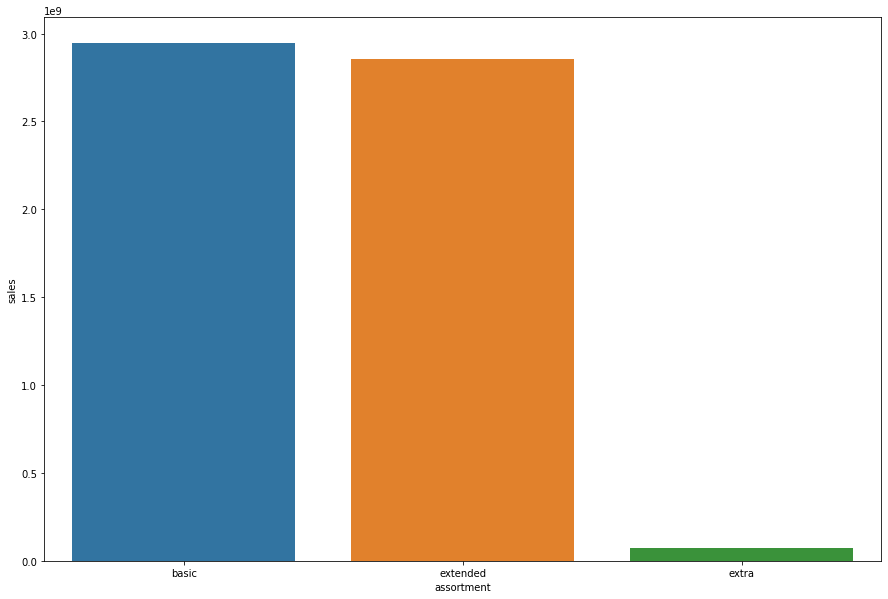

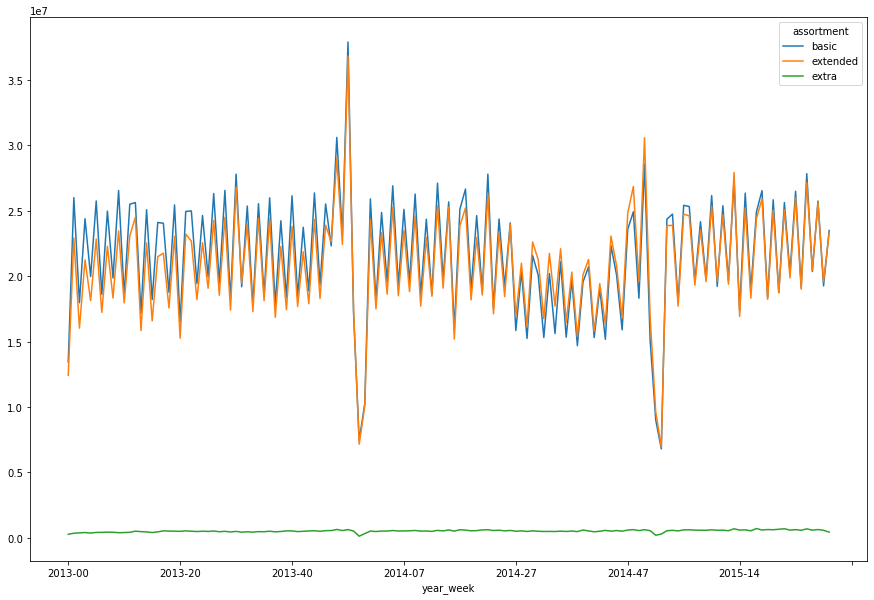

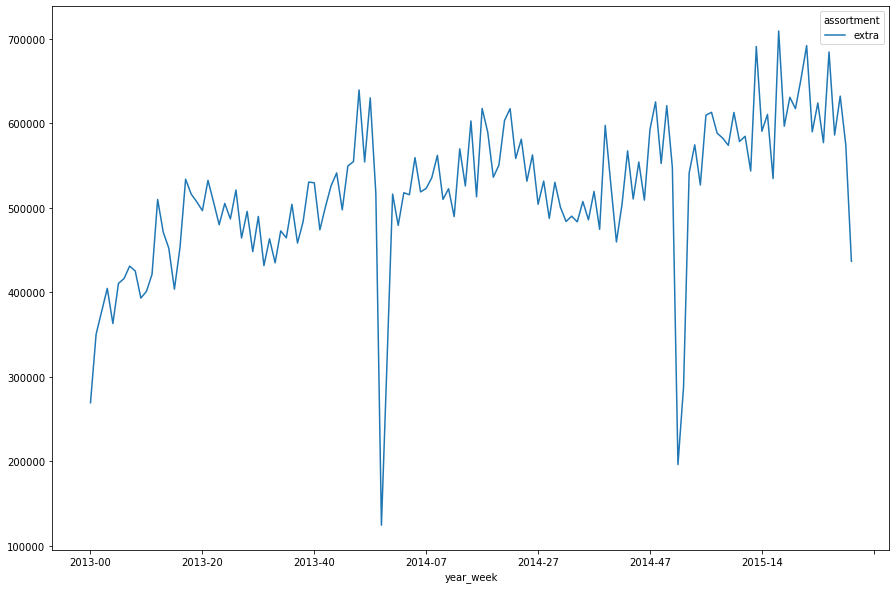

In [39]:
aux1 = df4[['assortment','sales']].groupby('assortment').sum().reset_index()
sns.barplot(x='assortment', y='sales', data=aux1);

aux2 = df4[['assortment','sales','year_week']].groupby(['year_week','assortment']).sum().reset_index()
aux2.pivot(index='year_week', columns= 'assortment', values ='sales').plot();

aux3 = aux2[aux2['assortment'] == 'extra']
aux3.pivot(index='year_week', columns= 'assortment', values ='sales').plot();


In [40]:
aux3.head()

,year_week,assortment,sales
2,2013-00,extra,269404
5,2013-01,extra,350279
8,2013-02,extra,377207
11,2013-03,extra,404662
14,2013-04,extra,363061


### **H2.** Stores having competence stores nearby should have lesser selling volume
**FALSE**, stores having competence stores nearby have higher selling volume


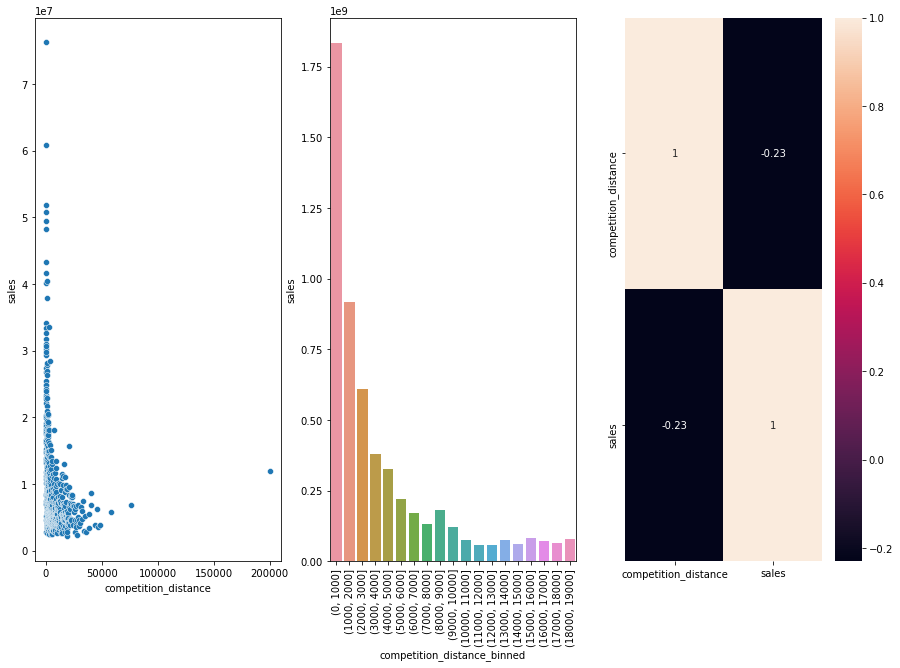

In [41]:
aux1 = df4[['competition_distance','sales']].groupby('competition_distance').sum().reset_index()
plt.subplot(1,3,1)
sns.scatterplot(x = aux1['competition_distance'], y='sales', data = aux1)

plt.subplot(1,3,2)
bins = list(np.arange(0,20000,1000))
aux1['competition_distance_binned'] = pd.cut(aux1['competition_distance'], bins=bins)
aux2 = aux1[['competition_distance_binned','sales']].groupby('competition_distance_binned').sum().reset_index()
sns.barplot(x='competition_distance_binned',y='sales', data= aux2)
plt.xticks(rotation=90)

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method = 'pearson'), annot = True);

### **H3.**  Stores with lasting competition sell more
**FALSE** stores with lasting competition sell less

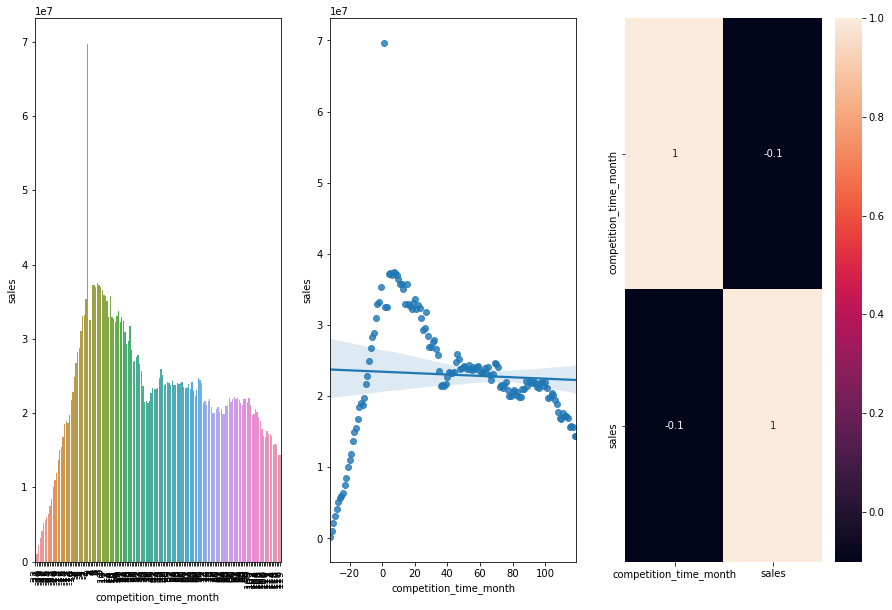

In [42]:
plt.subplot(1,3,1)
aux1 = df4[['competition_time_month', 'sales']].groupby('competition_time_month').sum().reset_index()
aux2 = aux1[(aux1['competition_time_month']<120) & (aux1['competition_time_month']!=0)]
sns.barplot(x='competition_time_month', y='sales', data = aux2)
plt.xticks(rotation =90);

plt.subplot(1,3,2)
sns.regplot(x='competition_time_month',y='sales', data = aux2);

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method ='pearson'), annot=True);

### **H4.**  Longer active promos should lead to higher sellings
**FALSE** stores with lasting promos are selling less, after a certain promo period

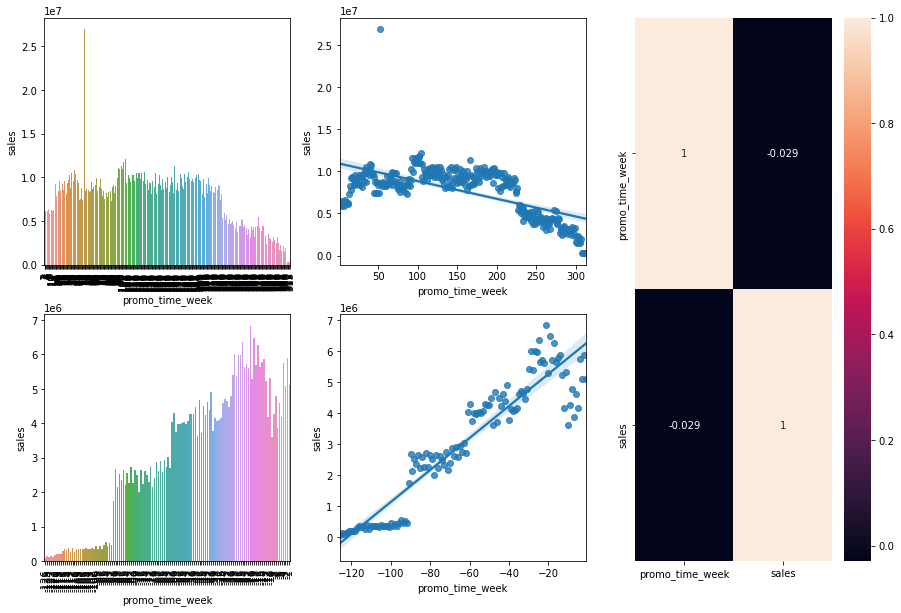

In [43]:
aux1 = df4[['promo_time_week', 'sales']].groupby('promo_time_week').sum().reset_index()

grid = gridspec.GridSpec(2,3)

plt.subplot(grid[0,0])
aux2 = aux1[aux1['promo_time_week']>0] # extended promo
sns.barplot(x='promo_time_week',y='sales', data= aux2)
plt.xticks(rotation =90);

plt.subplot(grid[0,1])
sns.regplot(x='promo_time_week',y='sales', data= aux2)

plt.subplot(grid[1,0])
aux3 = aux1[aux1['promo_time_week']<0] # promo regular
sns.barplot(x='promo_time_week',y='sales', data= aux3)
plt.xticks(rotation =90);

plt.subplot(grid[1,1])
sns.regplot(x='promo_time_week',y='sales', data= aux3)

plt.subplot(grid[:,2])
sns.heatmap(aux1.corr(method = 'pearson'), annot = True);

### **H5.** Stores with more days with promos  should display higher sellings

### **H7.** Stores with more consecutive promos should display higher sellings
**FALSE** Stores displaying more consecutive promos are actually selling less

In [44]:
df4[['promo','promo2','sales']].groupby(['promo','promo2']).sum().reset_index()

,promo,promo2,sales
0,0,0,1482612096
1,0,1,1289362241
2,1,0,1628930532
3,1,1,1472275754


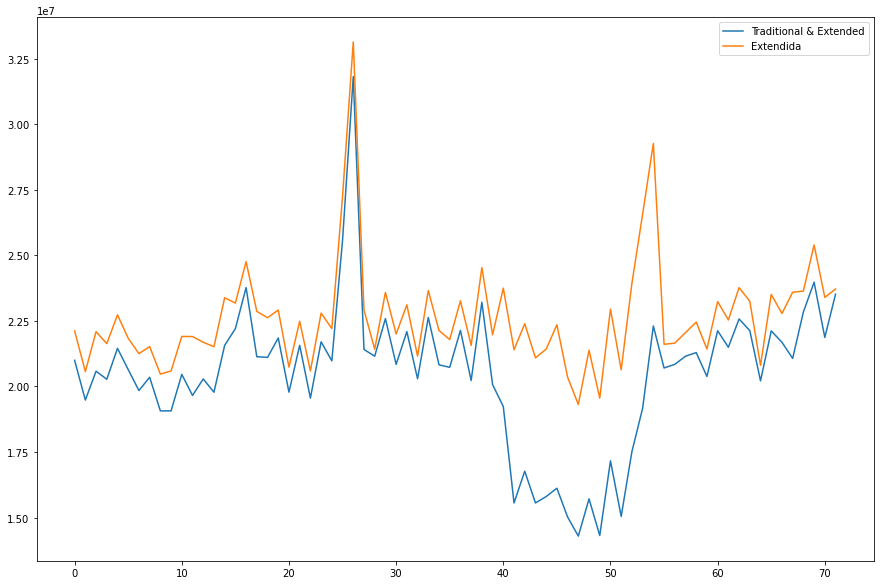

In [45]:
aux1 = df4[(df4['promo'] == 1)&(df4['promo2'] ==1)][['year_week','sales']].groupby('year_week').sum().reset_index()
ax = aux1.plot()

aux2 = df4[(df4['promo'] == 1)&(df4['promo2'] ==0)][['year_week','sales']].groupby('year_week').sum().reset_index()
aux2.plot(ax=ax)

ax.legend(labels = ['Traditional & Extended','Extendida']);


### **H7**. Stores being opened on crhistmas should display higher selling volume
**FALSE**. No higher selling volume is displayed on crhistmas

<AxesSubplot:xlabel='year', ylabel='sales'>

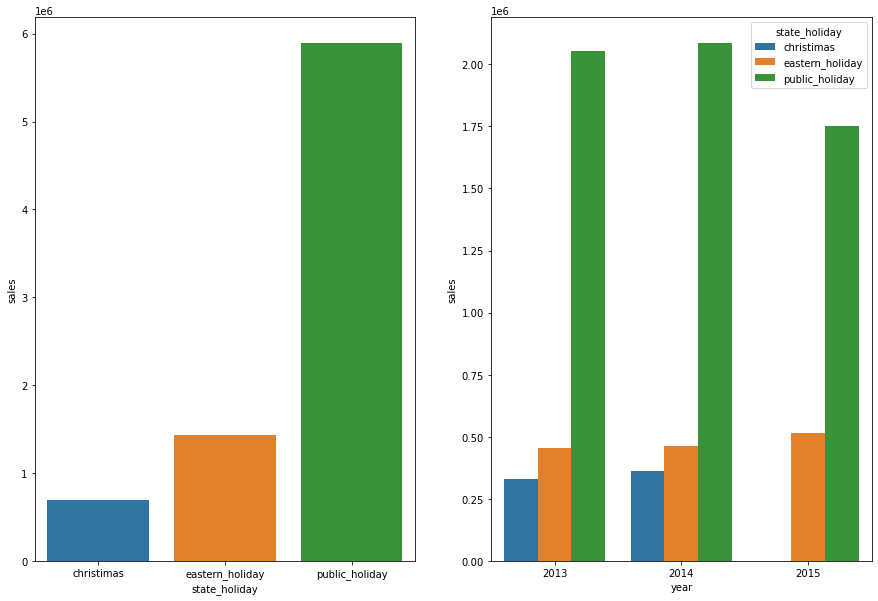

In [46]:
aux = df4[df4['state_holiday'] != 'regular_day']

plt.subplot(1,2,1)
aux1 = aux[['state_holiday','sales']].groupby('state_holiday').sum().reset_index()
sns.barplot(x='state_holiday', y='sales', data=aux1)

plt.subplot(1,2,2)
aux2 = aux[['year','state_holiday', 'sales']].groupby(['year', 'state_holiday']).sum().reset_index()
sns.barplot(x='year', y='sales', hue= 'state_holiday', data=aux2)

### **H8**. Stores should have higher sellings through years


<AxesSubplot:>

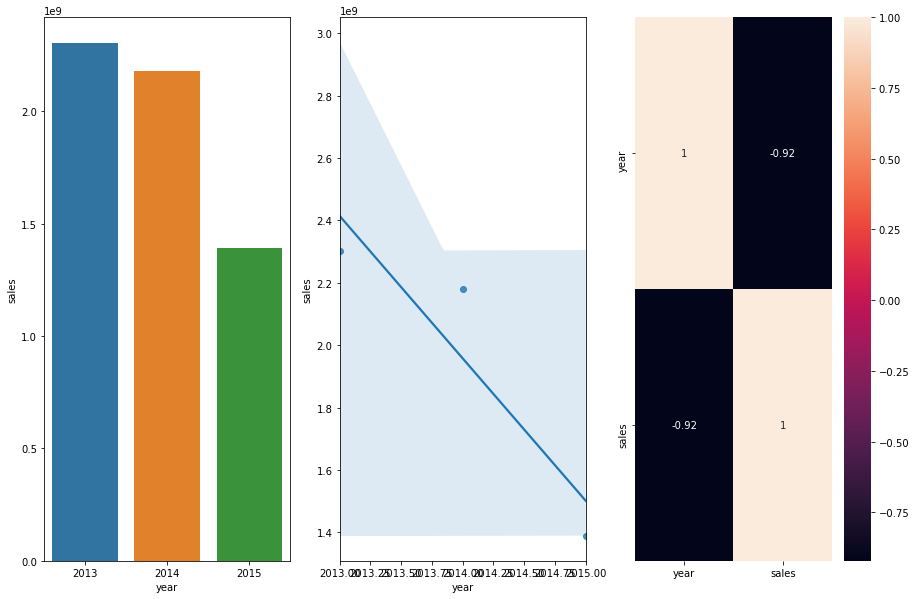

In [47]:
aux1 = df4[['year','sales']].groupby('year').sum().reset_index()
plt.subplot(1,3,1)
sns.barplot(x='year', y='sales', data =aux1)
plt.subplot(1,3,2)
sns.regplot(x='year', y='sales', data =aux1)
plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True)

### **H9**. Stores should have higher selling volume on second semester each year
**FALSE**. Stores display higher selling volume on first semester


<AxesSubplot:>

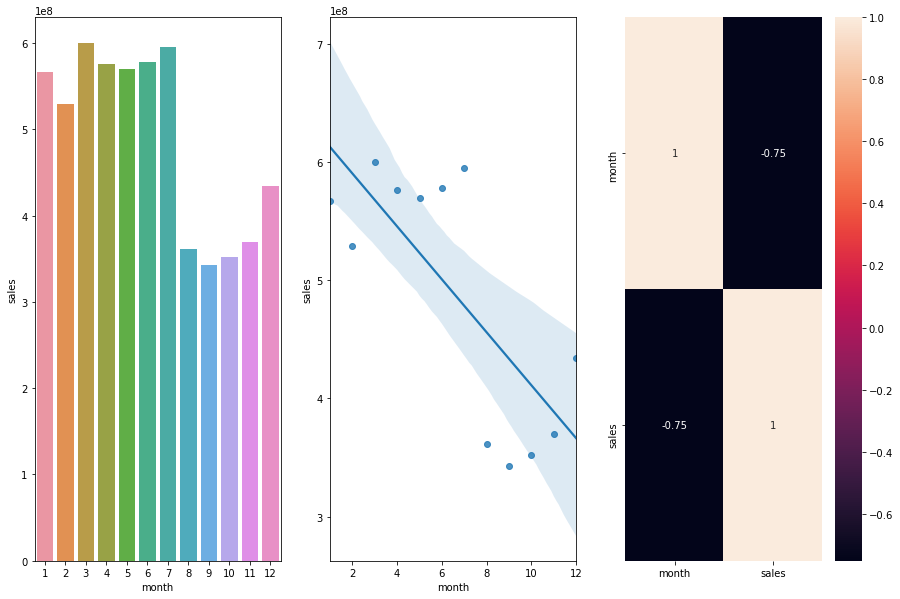

In [48]:
aux1 = df4[['month','sales']].groupby('month').sum().reset_index()
plt.subplot(1,3,1)
sns.barplot(x='month', y='sales', data =aux1)
plt.subplot(1,3,2)
sns.regplot(x='month', y='sales', data =aux1)
plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True)

### **H10**. Stores should have higher selling volume after day 10 of month
**TRUE**. Stores display higher selling volume after day 10

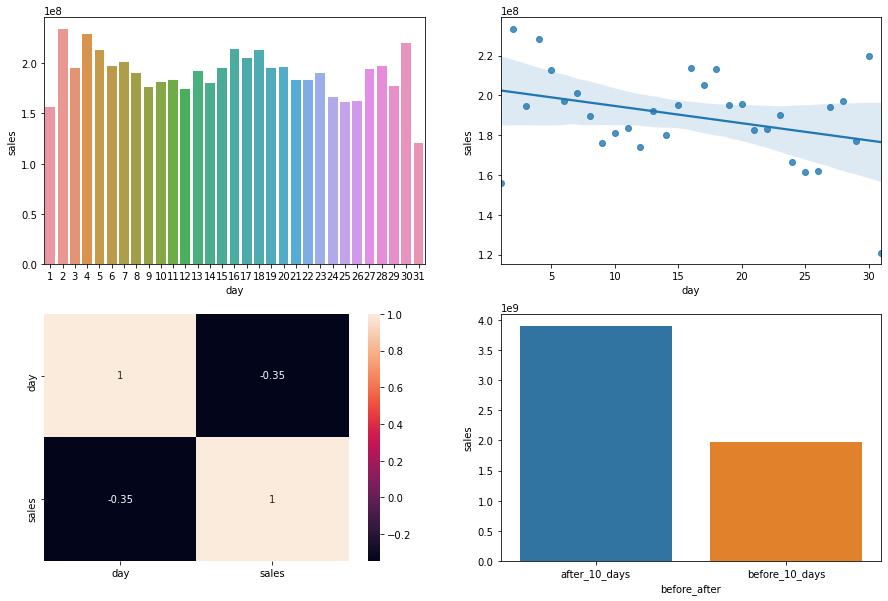

In [49]:
aux1 = df4[['day','sales']].groupby('day').sum().reset_index()
plt.subplot(2,2,1)
sns.barplot(x='day', y='sales', data =aux1)
plt.subplot(2,2,2)
sns.regplot(x='day', y='sales', data =aux1)
plt.subplot(2,2,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True)
plt.subplot(2,2,4)

aux1['before_after'] = aux1['day'].apply(lambda x:'before_10_days' if x <= 10 else 'after_10_days')
aux2 = aux1[['before_after','sales']].groupby('before_after').sum().reset_index()
sns.barplot(x='before_after', y='sales', data = aux2);

### **H11**. Stores should have lesser selling volume on weekends
**TRUE**. Stores display lesser selling volume on weekends


<AxesSubplot:>

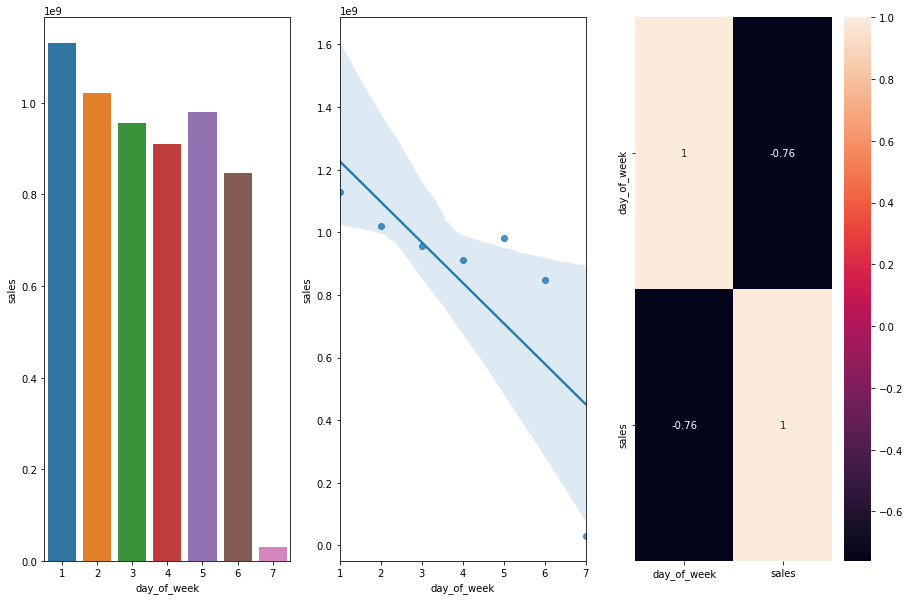

In [50]:
aux1 = df4[['day_of_week','sales']].groupby('day_of_week').sum().reset_index()
plt.subplot(1,3,1)
sns.barplot(x='day_of_week', y='sales', data =aux1)
plt.subplot(1,3,2)
sns.regplot(x='day_of_week', y='sales', data =aux1)
plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True)

### **H12**. Stores should have lesser selling volume on school holidays
**TRUE**. Stores display lesser selling volume on school holiday, except July and August. 

<AxesSubplot:xlabel='month', ylabel='sales'>

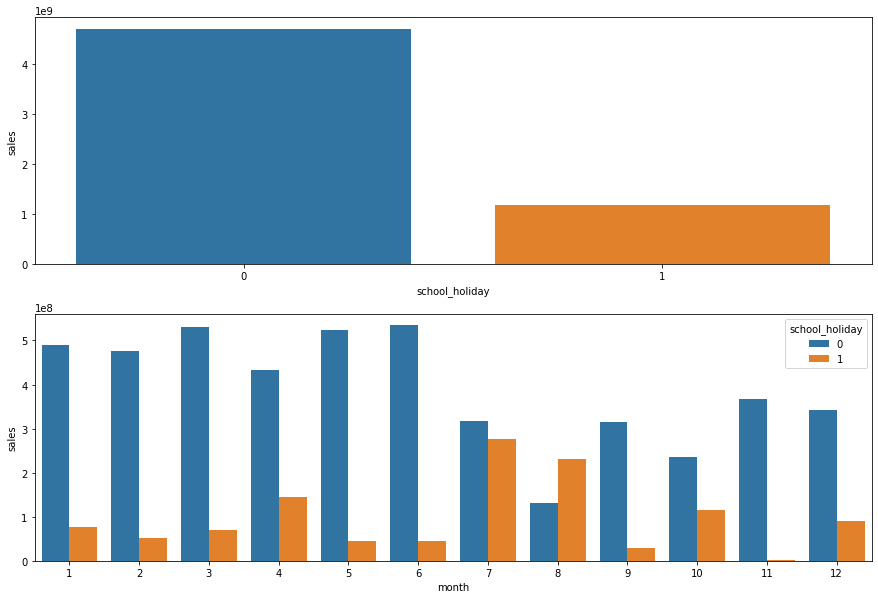

In [51]:
plt.subplot(2,1,1)
aux1 = df4[['school_holiday','sales']]. groupby('school_holiday').sum().reset_index()
sns.barplot(x='school_holiday', y='sales', data= aux1)

plt.subplot(2,1,2)
aux2 = df4[['month','school_holiday','sales']]. groupby(['month','school_holiday']).sum().reset_index()
sns.barplot(x='month', y='sales',hue='school_holiday', data= aux2)

## Multivariate Analysis

### Numerical Attributes

<AxesSubplot:>

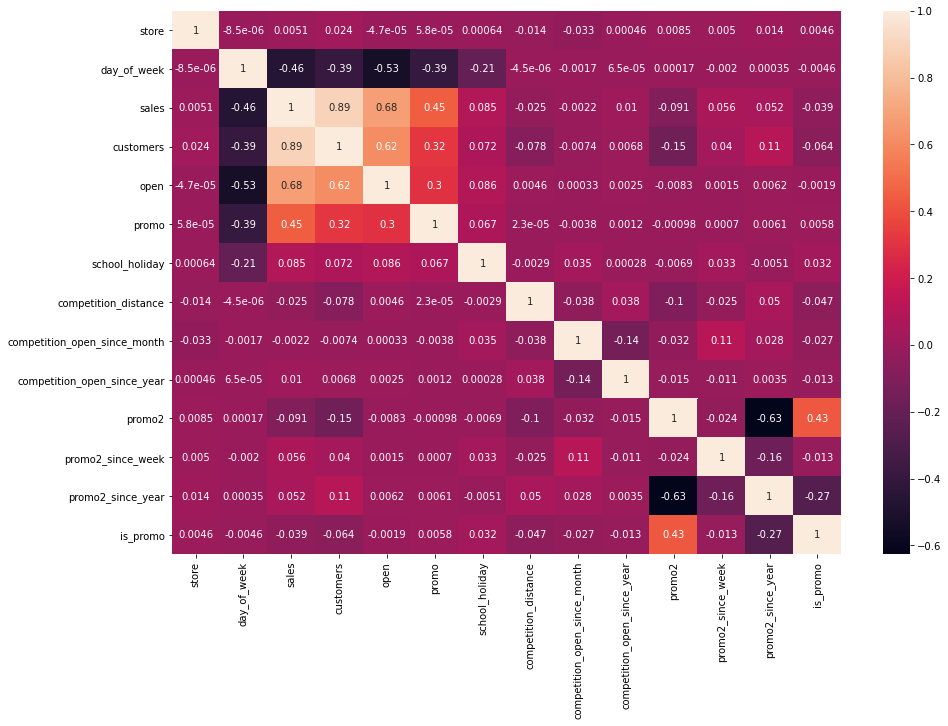

In [52]:
correlation = num_attributes.corr(method='pearson')
sns.heatmap(correlation, annot =True)

### Categorical Attributes

In [53]:
def cramer_v(x,y): 
    cm = pd.crosstab(x,y).values
    n = cm.sum()
    r, k = cm.shape
    chi2 = ss.chi2_contingency(cm)[0]
    chi2corr = max(0,chi2-(k-1)*(r-1)/(n-1))
    
    kcorr = k-(k-1)**2/(n-1)
    rcorr = r-(r-1)**2/(n-1)
    
    return np.sqrt((chi2corr/n)/(min(rcorr-1,kcorr-1)))

<AxesSubplot:>

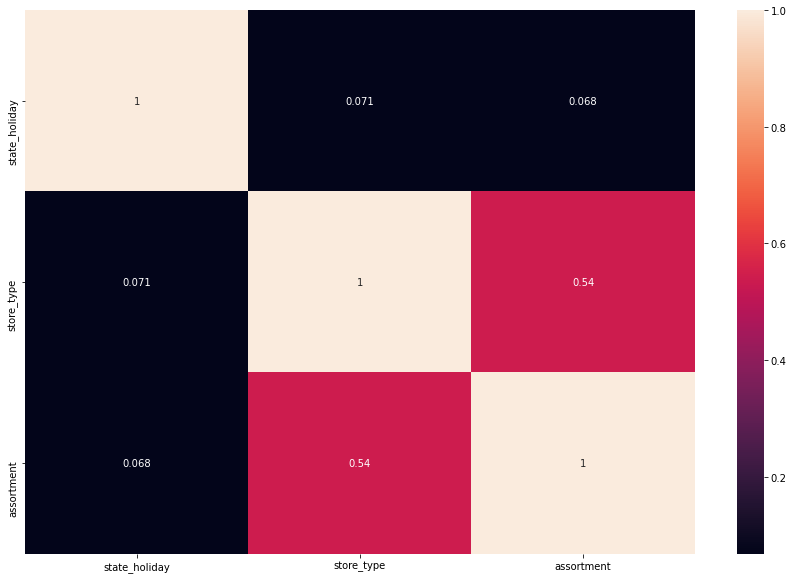

In [54]:
# only categoricaldata
a  = df4.select_dtypes(include ='object')


# Compute Cramer V 
a1 = cramer_v(a['state_holiday'],a['state_holiday'])
a2 = cramer_v(a['state_holiday'],a['store_type'])
a3 = cramer_v(a['state_holiday'],a['assortment'])

a4 = cramer_v(a['store_type'],a['state_holiday'])
a5 = cramer_v(a['store_type'],a['store_type'])
a6 = cramer_v(a['store_type'],a['assortment'])

a7 = cramer_v(a['assortment'],a['state_holiday'])
a8 = cramer_v(a['assortment'],a['store_type'])
a9 = cramer_v(a['assortment'],a['assortment'])

# Final data frame
d = pd.DataFrame({'state_holiday':[a1,a2,a3],
              'store_type':[a4,a5,a6],
              'assortment':[a7,a8,a9]})
d = d.set_index(d.columns)

sns.heatmap(d, annot= True)

# Data Preparation 

In [55]:
df5 = df4.copy()
df5.head()

,store,day_of_week,date,sales,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,...,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,1,regular_day,1,c,basic,1270.0,...,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,1,regular_day,1,a,basic,570.0,...,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,1,regular_day,1,a,basic,14130.0,...,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1,regular_day,1,c,extended,620.0,...,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,1,regular_day,1,a,basic,29910.0,...,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0


##   Data Normalization

## Data Rescaling

In [56]:
rs = RobustScaler()
mms = MinMaxScaler()
# competition distance
df5['competition_distance'] = rs.fit_transform(df5[['competition_distance']].values)
# year
df5['year'] = mms.fit_transform(df5[['year']].values)
# competition time month
df5['competition_time_month'] = rs.fit_transform(df5[['competition_time_month']].values)
# promo time week
df5['promo_time_week'] = mms.fit_transform(df5[['promo_time_week']].values)

## Data Transformation

### Encoding

In [57]:
# state_holiday - one hot encoding
df5 = pd.get_dummies(df5, prefix = 'state_holiday', columns = ['state_holiday'])

In [58]:
# store_type - label encoding
le = LabelEncoder()
df5['store_type'] = le.fit_transform( df5['store_type'])

In [59]:
# assortment - ordinal encoding 
assortment_dict = {'basic':1,'extra':2,'extended':3}
df5['assortment'] = df5['assortment'].map(assortment_dict)

### Response Variable Transformation 

In [60]:
df5['sales'] = np.log1p(df5['sales'])

In [61]:
# day of week
df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x : np.sin(x*2.*np.pi/7))
df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x : np.cos(x*2.*np.pi/7))

# month
df5['month_sin'] = df5['month'].apply(lambda x : np.sin(x*2.*np.pi/12))
df5['month_cos'] = df5['month'].apply(lambda x : np.cos(x*2.*np.pi/12))

# day
df5['day_sin'] = df5['day'].apply(lambda x : np.sin(x*2.*np.pi/30))
df5['day_cos'] = df5['day'].apply(lambda x : np.cos(x*2.*np.pi/30))

# week of year
df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x : np.sin(x*2.*np.pi/52))
df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x : np.cos(x*2.*np.pi/52))

In [62]:
df5.head()

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,...,state_holiday_public_holiday,state_holiday_regular_day,day_of_week_sin,day_of_week_cos,month_sin,month_cos,day_sin,day_cos,week_of_year_sin,week_of_year_cos
0,1,5,2015-07-31,8.568646,1,1,2,1,-0.170968,9,...,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
1,2,5,2015-07-31,8.710290,1,1,0,1,-0.283871,11,...,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
2,3,5,2015-07-31,9.025816,1,1,0,1,1.903226,12,...,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
3,4,5,2015-07-31,9.546527,1,1,2,3,-0.275806,9,...,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
4,5,5,2015-07-31,8.481151,1,1,0,1,4.448387,4,...,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984


# Feature Selection


In [71]:
df6 = df5.copy()

In [72]:
df6.head()

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,...,state_holiday_public_holiday,state_holiday_regular_day,day_of_week_sin,day_of_week_cos,month_sin,month_cos,day_sin,day_cos,week_of_year_sin,week_of_year_cos
0,1,5,2015-07-31,8.568646,1,1,2,1,-0.170968,9,...,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
1,2,5,2015-07-31,8.710290,1,1,0,1,-0.283871,11,...,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
2,3,5,2015-07-31,9.025816,1,1,0,1,1.903226,12,...,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
3,4,5,2015-07-31,9.546527,1,1,2,3,-0.275806,9,...,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
4,5,5,2015-07-31,8.481151,1,1,0,1,4.448387,4,...,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984


## Split dataframe into training and test dataset

In [73]:
cols_drop = ['week_of_year','day','month','day_of_week', 'promo_since', 'competition_since', 'year_week']
df6 = df6.drop(cols_drop, axis=1)

In [79]:
df6[['store','date']].groupby('store').max().reset_index()['date'][0]- datetime.timedelta(days = 7*6)

Timestamp('2015-06-19 00:00:00')

In [82]:
# Training dataset
X_train = df6[df6['date'] < '2015-06-19']
y_train = X_train['sales']

# Testing dataset
X_test = df6[df6['date'] >= '2015-06-19']
y_test = X_test['sales']

print('Training Min Date: {}'.format(X_train['date'].min()))
print('Training Max Date: {}'.format(X_train['date'].max()))

print('Testing Min Date: {}'.format(X_test['date'].min()))
print('Testing Max Date: {}'.format(X_test['date'].max()))

Training Min Date: 2013-01-01 00:00:00
Training Max Date: 2015-06-18 00:00:00
Testing Min Date: 2015-06-19 00:00:00
Testing Max Date: 2015-07-31 00:00:00


## Boruta as Feature Selector

In [86]:
# training and testing dataset for Boruta
X_train_n = X_train.drop(['date','sales'], axis = 1).values
y_train_n = y_train.ravel()

# define random forest regressor 
rf = RandomForestRegressor(n_jobs = -1)

# define Boruta 
boruta = BorutaPy( rf, n_estimators = 'auto', verbose =2, random_state = 42).fit(X_train_n, y_train_n)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	18
Tentative: 	0
Rejected: 	9


BorutaPy finished running.

Iteration: 	9 / 100
Confirmed: 	18
Tentative: 	0
Rejected: 	9


### Best features from Boruta

In [89]:
cols_selected = boruta.support_.tolist()

#best features
X_train_fs = X_train.drop(['date','sales'], axis = 1)
cols_selected_boruta = X_train_fs.iloc[:,cols_selected].columns.to_list()

# not selected Boruta
cols_not_selected_boruta = list(np.setdiff1d(X_train_fs.columns, cols_selected_boruta))

In [92]:
cols_selected_boruta

['store',
 'promo',
 'store_type',
 'assortment',
 'competition_distance',
 'competition_open_since_month',
 'competition_open_since_year',
 'promo2',
 'promo2_since_week',
 'promo2_since_year',
 'competition_time_month',
 'promo_time_week',
 'day_of_week_sin',
 'day_of_week_cos',
 'month_cos',
 'day_sin',
 'day_cos',
 'week_of_year_cos']

In [64]:
import pandas as pd
import pandas.io.sql as sqlio
import psycopg2

In [65]:
conn = psycopg2.connect(
            host = "127.0.0.1", 
            database = "Classroom", 
            user = "postgres", 
            password = "1032441403"
)
sql = "SELECT * FROM science_class;"
dat = sqlio.read_sql_query(sql, conn)
conn = None

In [66]:
dat

,enrollment_no,student_name,science_marks
0,4,Linnett,79
1,5,Jayden,45
2,6,Sam,63
3,7,Zooey,82
4,9,Jon,38
5,10,Sansa,54
6,11,Arya,78
7,2,Olive,54
8,3,Brutus,98
9,1,popeye,45
